In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [28]:
def single_bound_diffusion(v,a,dt=1e-4,dB=1e-2):
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t

In [3]:
dt = 1e-4
dB = np.sqrt(dt)
v = 1
a = 2
N_sim = int(50e3)

In [ ]:
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a,dt,dB) for _ in range(N_sim))

In [5]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


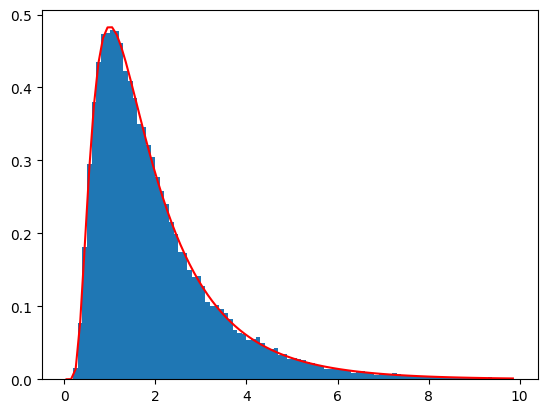

In [6]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
plt.hist(sim_results, bins=bins, density=True);

t_pts = bins[:-1] + bin_width/2
pdf = [rho_A_t_fn(t, v, a) for t in t_pts]
plt.plot(t_pts, pdf, 'r-')

# MNLE

In [7]:
from sbi.inference import MNLE

## proposal and prior

In [8]:
# priors and proposal
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
import torch

# Define the distributions for "v" and "a"
v_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))
a_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))

# Group the distributions into a prior
prior = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

# Group the distributions into a proposal (if needed)
proposal = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

## simulator

In [9]:
import torch
import numpy as np

def simulate_single_bound_diffusion(params):
    """
    Simulates single-bound diffusion for a batch of parameters.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    v, a = params[:, 0], params[:, 1]  # Extract v and a
    batch_size = params.size(0)
    dt = 1e-4
    dB = np.sqrt(dt)

    decision_times = []
    for i in range(batch_size):
        DV = 0.0  # Initialize decision variable
        t = 0.0   # Initialize time
        while True:
            DV += v[i].item() * dt + np.random.normal(0, dB)  # Update decision variable
            t += dt  # Increment time
            if DV >= a[i].item():  # Check if threshold is crossed
                decision_times.append(t)
                break

    # Convert decision times to a tensor of shape (batch_size, 1)
    return torch.tensor(decision_times).reshape(-1, 1)

## In parallel?

In [34]:
import torch

def simulate_single_bound_diffusion_parallel(params):
    """
    Simulates single-bound diffusion for a batch of parameters in parallel.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    params = params.cpu().numpy()  # Convert to NumPy for compatibility with Joblib
    results = Parallel(n_jobs=-1)(
        delayed(single_bound_diffusion)(v, a) for v, a in params
    )
    return torch.tensor(results).reshape(-1, 1)


test simulator

In [30]:
params = torch.tensor([[0.5, 1.0], [0.3, 1.5], [0.7, 0.8]])  # Example batch of parameters
decision_times = simulate_single_bound_diffusion_parallel(params)
print(decision_times)


tensor([[1.3668],
        [2.0104],
        [0.6468]])


## trainer MNLE

In [82]:
N_sim = int(100e3)

In [83]:
theta = proposal.sample((N_sim,))

In [84]:
x = simulate_single_bound_diffusion_parallel(theta)

In [85]:
theta.shape, x.shape

(torch.Size([100000, 2]), torch.Size([100000, 1]))

In [86]:
from sbi.inference import SNLE
trainer = SNLE()
estimator = trainer.append_simulations(theta, x).train(training_batch_size=512)


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 52 epochs.

# likelihood

In [87]:
v = 1; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a) for _ in range(int(50e3)))

In [88]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
t_pts = bins[:-1] + bin_width/2

In [89]:
v, a = 1.0, 2.0  # Drift rate and threshold
theta = torch.tensor([[v, a]] * len(t_pts))  # Repeat (v, a) for all t_pts

In [90]:
# Observations (t_pts as reaction times)
t_pts_tensor = torch.tensor(t_pts).reshape(-1, 1)  # Reshape to (n_samples, 1)

In [91]:
t_pts_tensor.shape, theta.shape

(torch.Size([99, 1]), torch.Size([99, 2]))

In [92]:
t_pts_tensor_reshaped = t_pts_tensor.unsqueeze(0)  
t_pts_tensor_reshaped.shape

torch.Size([1, 99, 1])

In [93]:
t_pts_tensor_reshaped = t_pts_tensor_reshaped.to(dtype=torch.float32)
theta = theta.to(dtype=torch.float32)

In [94]:
log_likelihood = estimator.log_prob(t_pts_tensor_reshaped, theta)


In [95]:
likelihood = torch.exp(log_likelihood)

In [96]:
# convert likelihood to numpy array
likelihood = likelihood.detach().numpy()

/tmp/ipykernel_1789096/43968720.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t_pts, [rho_A_t_fn(t, v, a) for t in t_pts], 'b-', label="theortical", color='g')


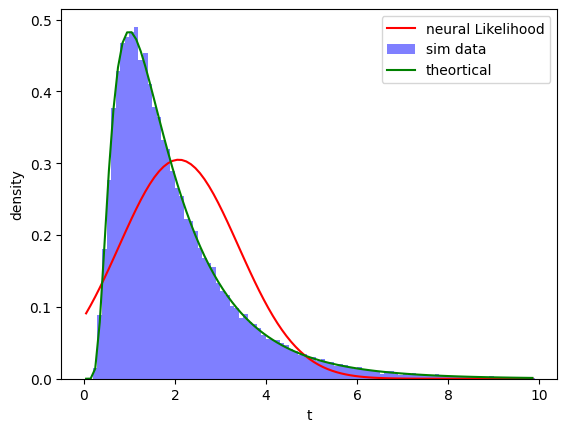

In [97]:
plt.plot(t_pts, likelihood.squeeze(), label="neural Likelihood", color='r')
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label="sim data", color='b')
plt.plot(t_pts, [rho_A_t_fn(t, v, a) for t in t_pts], 'b-', label="theortical", color='g')

plt.xlabel('t')
plt.ylabel('density')
plt.legend()
